# Imports

In [1]:
import numpy as np
import random
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from torchmetrics.classification import AUROC
from sklearn.metrics import roc_curve, auc
import os
from sklearn.model_selection import train_test_split
import shutil
from copy import deepcopy
from tqdm import tqdm
from matplotlib import pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Global settings

In [2]:
from torchvision.models.resnet import resnet18 as Model
from torchvision.models.resnet import ResNet18_Weights as ModelW
#from torchvision.models.vgg import vgg11_bn as Model
#from torchvision.models.vgg import VGG11_BN_Weights as ModelW
OPTIM_PARAMS = {"lr":1e-3}
OPTIM = torch.optim.AdamW
CRITERIUM = torch.nn.CrossEntropyLoss
BATCH_SIZE = 16
IMAGE_SIZE = 256
N_EPOCHS = 20
PATIENCE = 2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = 2 if DEVICE=='cuda' else 4 # fixed by kaggle notebook
SEED = 40

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Data split load

In [3]:
%%capture
!cp -r /kaggle/input/brain-tumors-256x256/Data /kaggle/working/Data

In [4]:
data_dir = '/kaggle/working/Data'
output_dir = '/kaggle/working/'

train_percent = 0.7
val_percent = 0.1
test_percent = 0.2

for root, dirs, files in os.walk(data_dir):
    if len(files) > 0:
        train_files, temp_files = train_test_split(files, test_size=(1 - train_percent), random_state=SEED)
        val_files, test_files = train_test_split(temp_files, test_size=(test_percent / (test_percent + val_percent)), random_state=SEED)
        for split_name,files in zip(["train","val","test"],[train_files,val_files,test_files]):
            new_output_dir = os.path.join(output_dir, split_name, os.path.relpath(root, data_dir))
            os.makedirs(new_output_dir, exist_ok=True)
            #print(new_output_dir)
            for file in files:
                src = os.path.join(root, file)
                dst = os.path.join(new_output_dir, file)
                shutil.move(src, dst)


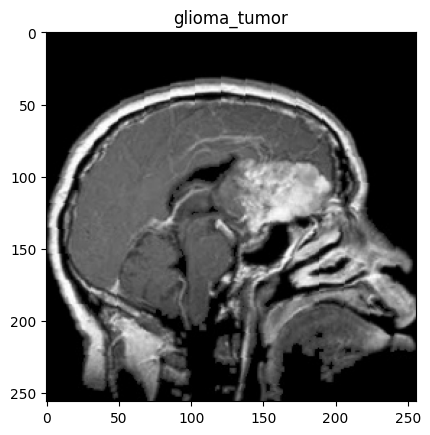

In [5]:
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomAffine(5,translate=[0,.1],scale=[.9,1.1]),
                                      transforms.ToTensor(),
                                      transforms.RandomErasing(),
                                     ])

transform_val = transforms.Compose([transforms.ToTensor(),
                                   ])

train = ImageFolder("train",
                    transform=transform_train,
                   )

val = ImageFolder("val",
                    transform=transform_val,
                   )

test = ImageFolder("test",
                    transform=transform_val,
                   )
plt.imshow(train[0][0].transpose(0,2).transpose(1,0))
plt.title(train.classes[train[0][1]])
plt.show()

In [6]:
# loaders :
train_loader = DataLoader(train,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=True,drop_last=True)
val_loader = DataLoader(val,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=False,drop_last=False)
test_loader = DataLoader(test,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=False,drop_last=False)

# Model

In [7]:
model = Model(weights=ModelW.IMAGENET1K_V1)
model.fc = torch.nn.Linear(in_features=model.fc.in_features,out_features=4) # resnet
#model.classifier = torch.nn.Linear(in_features=model.classifier[0].in_features,out_features=4) # vgg
model(torch.randn((BATCH_SIZE,3,IMAGE_SIZE,IMAGE_SIZE))).shape

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 233MB/s]


torch.Size([16, 4])

# Train

In [8]:
model.to(DEVICE)

optimizer = OPTIM(model.parameters(),**OPTIM_PARAMS)
criterium = CRITERIUM()
val_auc = AUROC(task="multiclass", num_classes=4).to(DEVICE)

best_model = deepcopy(model)
best_auc = 0
patience = 0

for epoch in range(N_EPOCHS):
    train_loss = 0
    train_total = 0
    model.train()
    for x,y in tqdm(train_loader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        output = model(x)
        loss = criterium(output,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        train_total += x.size(0)
    train_loss /= train_total
    
    val_loss = 0
    val_total = 0
    val_auc.reset()
    model.eval()
    with torch.no_grad():
        for x,y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            output = model(x)
            loss = criterium(output,y)
            val_loss += loss.item() * x.size(0)
            val_total += x.size(0)
            val_auc.update(output.softmax(dim=-1),y)
    val_loss /= val_total
    val_auc_ = val_auc.compute()
    
    # save
    if val_auc_ > best_auc :
        best_auc = val_auc_
        best_model = deepcopy(model)
        patience = 0
    else :
        patience += 1
    
    print("Epoch {} : train loss {:.4f} | val loss {:.4f} | val AUC {:.2f}".format(epoch,
                                                                                   train_loss,
                                                                                   val_loss,
                                                                                   val_auc_))
    
    # earlystopping
    if patience >= PATIENCE :
        break

100%|██████████| 135/135 [00:14<00:00,  9.55it/s]


Epoch 0 : train loss 0.8662 | val loss 2.7404 | val AUC 0.65


100%|██████████| 135/135 [00:07<00:00, 17.66it/s]


Epoch 1 : train loss 0.7345 | val loss 0.7914 | val AUC 0.92


100%|██████████| 135/135 [00:07<00:00, 17.34it/s]


Epoch 2 : train loss 0.6181 | val loss 2.0262 | val AUC 0.90


100%|██████████| 135/135 [00:07<00:00, 17.92it/s]


Epoch 3 : train loss 0.5047 | val loss 0.5677 | val AUC 0.97


100%|██████████| 135/135 [00:08<00:00, 16.18it/s]


Epoch 4 : train loss 0.4784 | val loss 0.8548 | val AUC 0.96


100%|██████████| 135/135 [00:07<00:00, 17.60it/s]


Epoch 5 : train loss 0.4793 | val loss 0.4009 | val AUC 0.98


100%|██████████| 135/135 [00:07<00:00, 17.30it/s]


Epoch 6 : train loss 0.4368 | val loss 0.2921 | val AUC 0.99


100%|██████████| 135/135 [00:07<00:00, 17.59it/s]


Epoch 7 : train loss 0.4304 | val loss 0.7650 | val AUC 0.97


100%|██████████| 135/135 [00:08<00:00, 16.62it/s]


Epoch 8 : train loss 0.3801 | val loss 1.2826 | val AUC 0.97


# Localization

In [9]:
%%capture
!pip install grad-cam

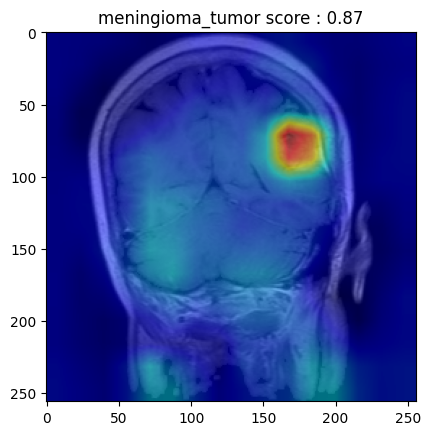

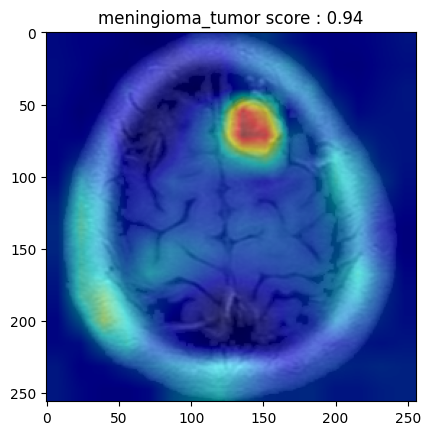

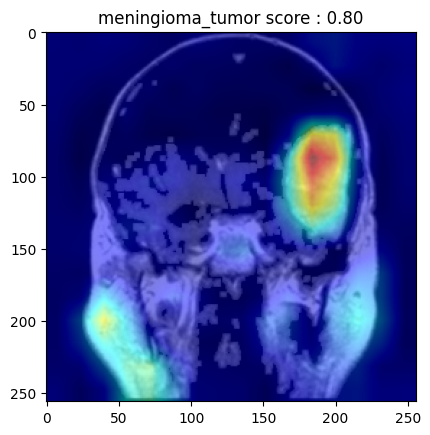

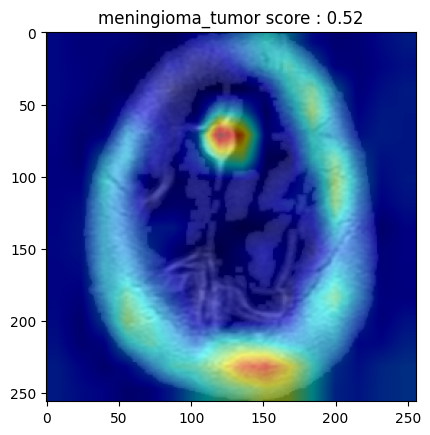

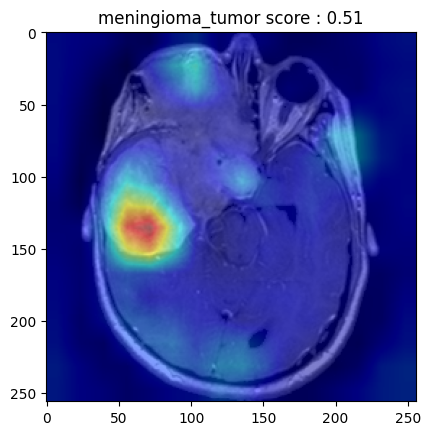

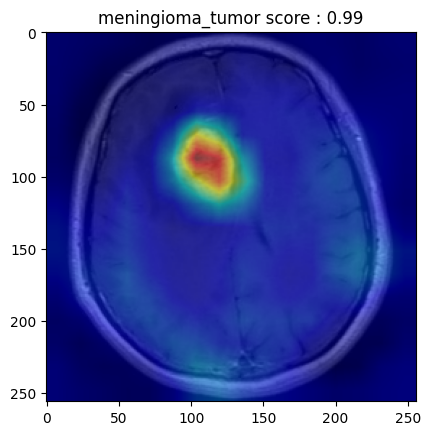

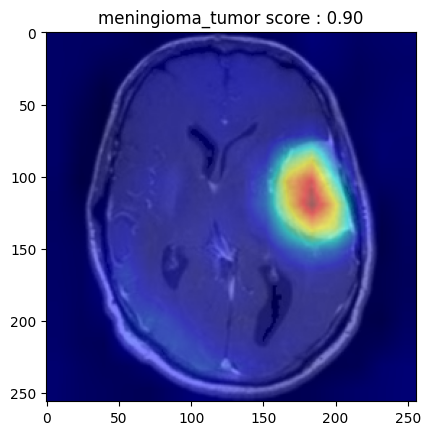

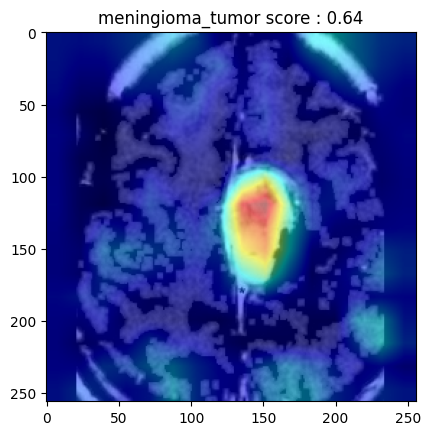

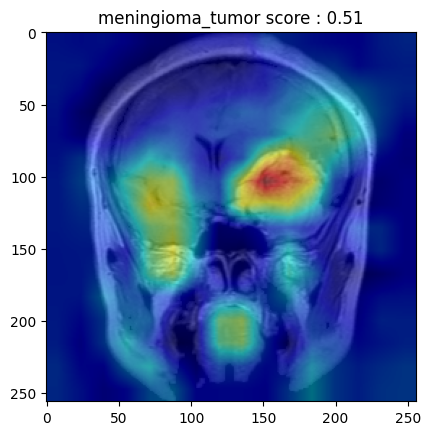

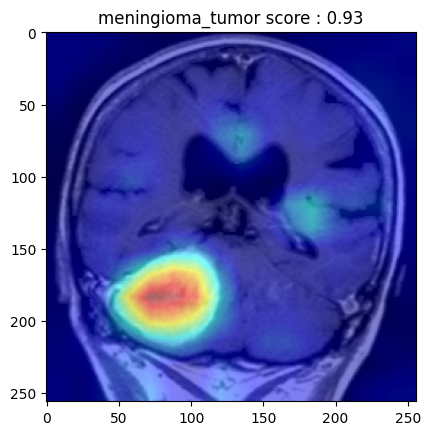

In [10]:
from pytorch_grad_cam import GradCAMPlusPlus as CAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

threshold = .3
show_count = 10
show_class_id = 1
cam = CAM(model=best_model,
          target_layers=[
                         best_model.layer3[-1], # resnet
                         #best_model.features[22],
                        ],
          use_cuda=DEVICE=="cuda")
targets = [ClassifierOutputTarget(show_class_id)]

count = 0
for batch in test_loader:
    x,y = batch
    x = x.to(DEVICE)
    out = best_model(x)
    pred = out.softmax(dim=-1).detach().cpu().numpy()
    predicted_class = out.softmax(dim=-1).argmax(axis=-1)

    for i in range(len(x)):
        if y[i] == show_class_id and y[i] == predicted_class[i] and pred[i,y[i]] > threshold:
            # if tumors & model is predicting it right
            grayscale_cam = cam(input_tensor=x[i:i+1,:], targets=targets)
            visualization = show_cam_on_image(x[i,:].cpu().numpy().transpose(1,2,0),
                                          grayscale_cam[0, :],
                                          use_rgb=True)
            plt.imshow(visualization)
            plt.title(test.classes[y[i]]+f' score : {pred[i,y[i]]:.2f}')
            plt.show()
            count +=1
        if count >= show_count :
            break
            
    if count >= show_count :
            break